In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn import externals
from io import StringIO
import pydotplus
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz

## **1 - Business Problem**

___Use decision trees to prepare a model on fraud data treating those who have taxable_income <= 30000 as "Risky" and others are "Good"___

**2 - Data collection and description**

In [2]:
from google.colab import files
data = files.upload()

Saving Fraud_check.csv to Fraud_check.csv


In [3]:
import io

In [4]:
df = pd.read_csv(io.StringIO(data['Fraud_check.csv'].decode('latin1')))

In [6]:
df1 = df.copy()

In [7]:
df1.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


In [8]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Taxable.Income,600.0,55208.375000,26204.827597,10003.0,32871.50,55074.5,78611.75,99619.0
City.Population,600.0,108747.368333,49850.075134,25779.0,66966.75,106493.5,150114.25,199778.0
Work.Experience,600.0,15.558333,8.842147,0.0,8.00,15.0,24.00,30.0


In [9]:
df1.isnull().sum()

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

In [10]:
df1.dtypes

Undergrad          object
Marital.Status     object
Taxable.Income      int64
City.Population     int64
Work.Experience     int64
Urban              object
dtype: object

**Outlier Check**

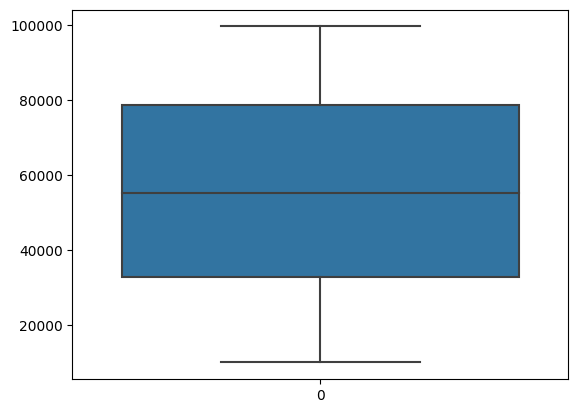

In [11]:
ax = sns.boxplot(df1['Taxable.Income'])

**There are no outliers in the data**

In [12]:
plt.rcParams["figure.figsize"] = 9,5

Skew: 0.030014788906377175
Kurtosis: -1.1997824607083138


<ipython-input-13-f81e33b9586a>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(df1['Taxable.Income'],shade=True,color='g')


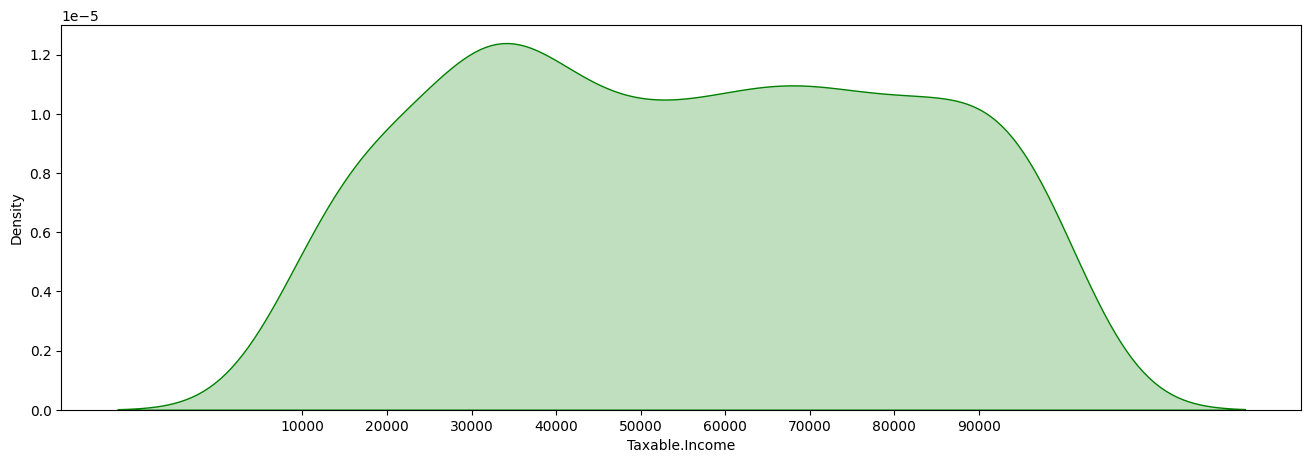

In [13]:
plt.figure(figsize=(16,5))
print("Skew: {}".format(df1['Taxable.Income'].skew()))
print("Kurtosis: {}".format(df1['Taxable.Income'].kurtosis()))
ax = sns.kdeplot(df1['Taxable.Income'],shade=True,color='g')
plt.xticks([i for i in range(10000,100000,10000)])
plt.show()

### **The data is Skwed on the right**

### **The data has negative Kurtosis**

In [14]:
obj_colum = df1.select_dtypes(include='object').columns.tolist()

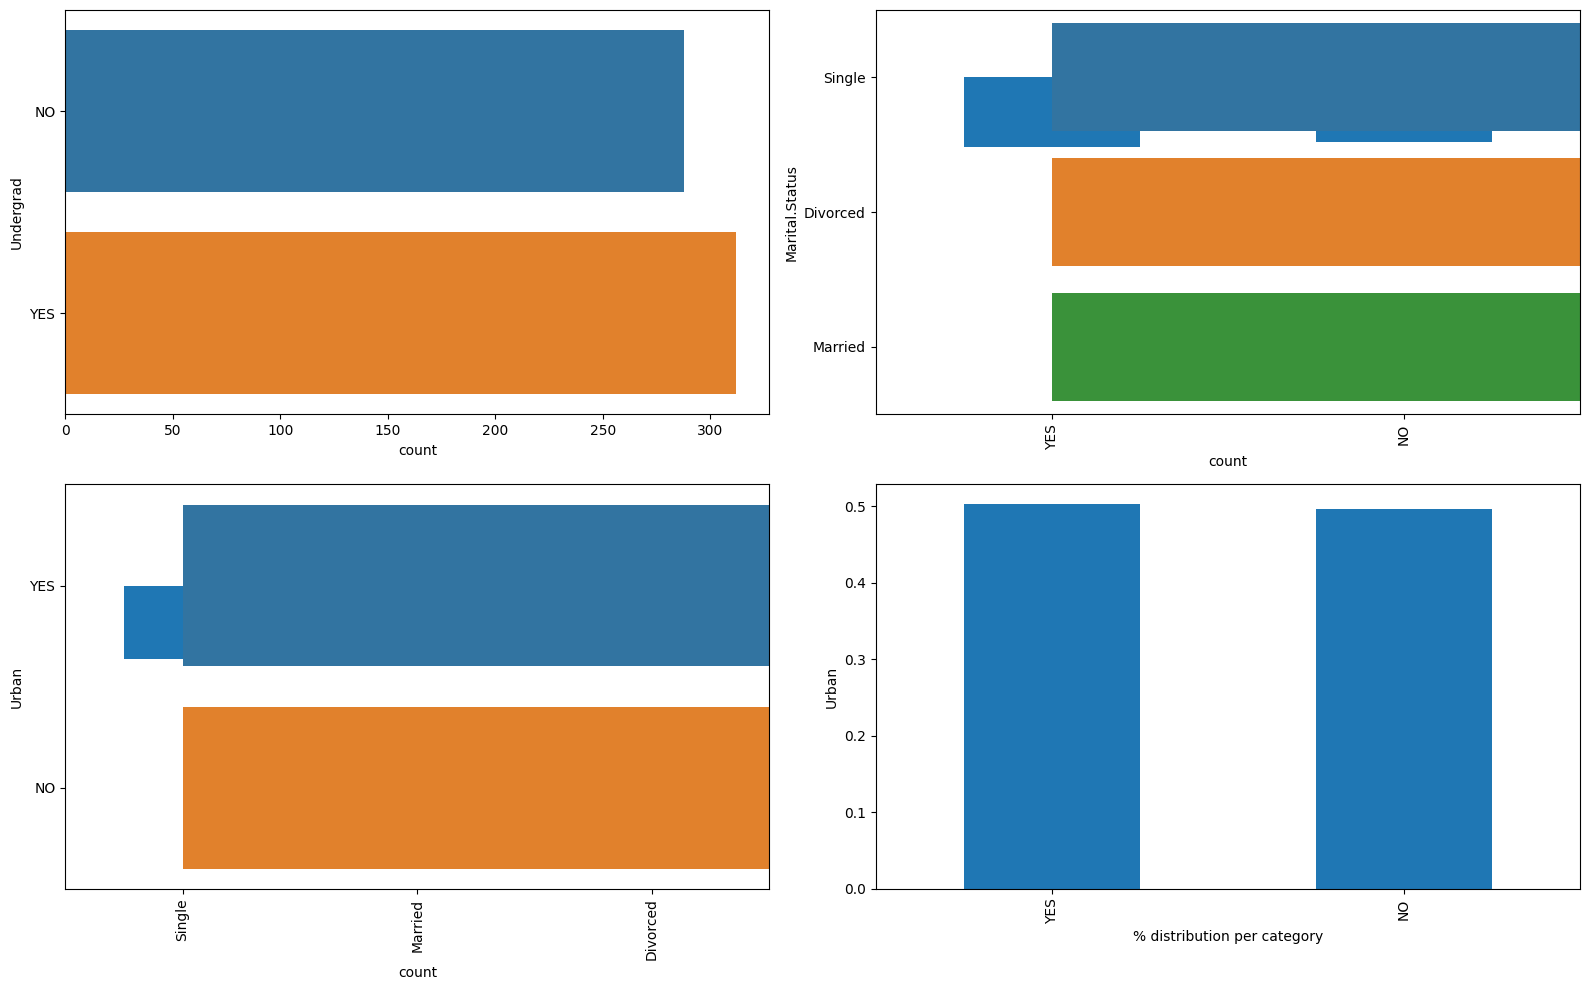

In [15]:
plt.figure(figsize=(16,10))
for i,col in enumerate(obj_colum,1):
    plt.subplot(2,2,i)
    sns.countplot(data=df1,y=col)
    plt.subplot(2,2,i+1)
    df1[col].value_counts(normalize=True).plot.bar()
    plt.ylabel(col)
    plt.xlabel('% distribution per category')
plt.tight_layout()
plt.show()

In [16]:
num_columns = df1.select_dtypes(exclude='object').columns.tolist()

<ipython-input-17-580362cfca90>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col],color='g',shade=True)
<ipython-input-17-580362cfca90>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col],color='g',shade=True)
<ipython-input-17-580362cfca90>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col],color='g',shade=True)


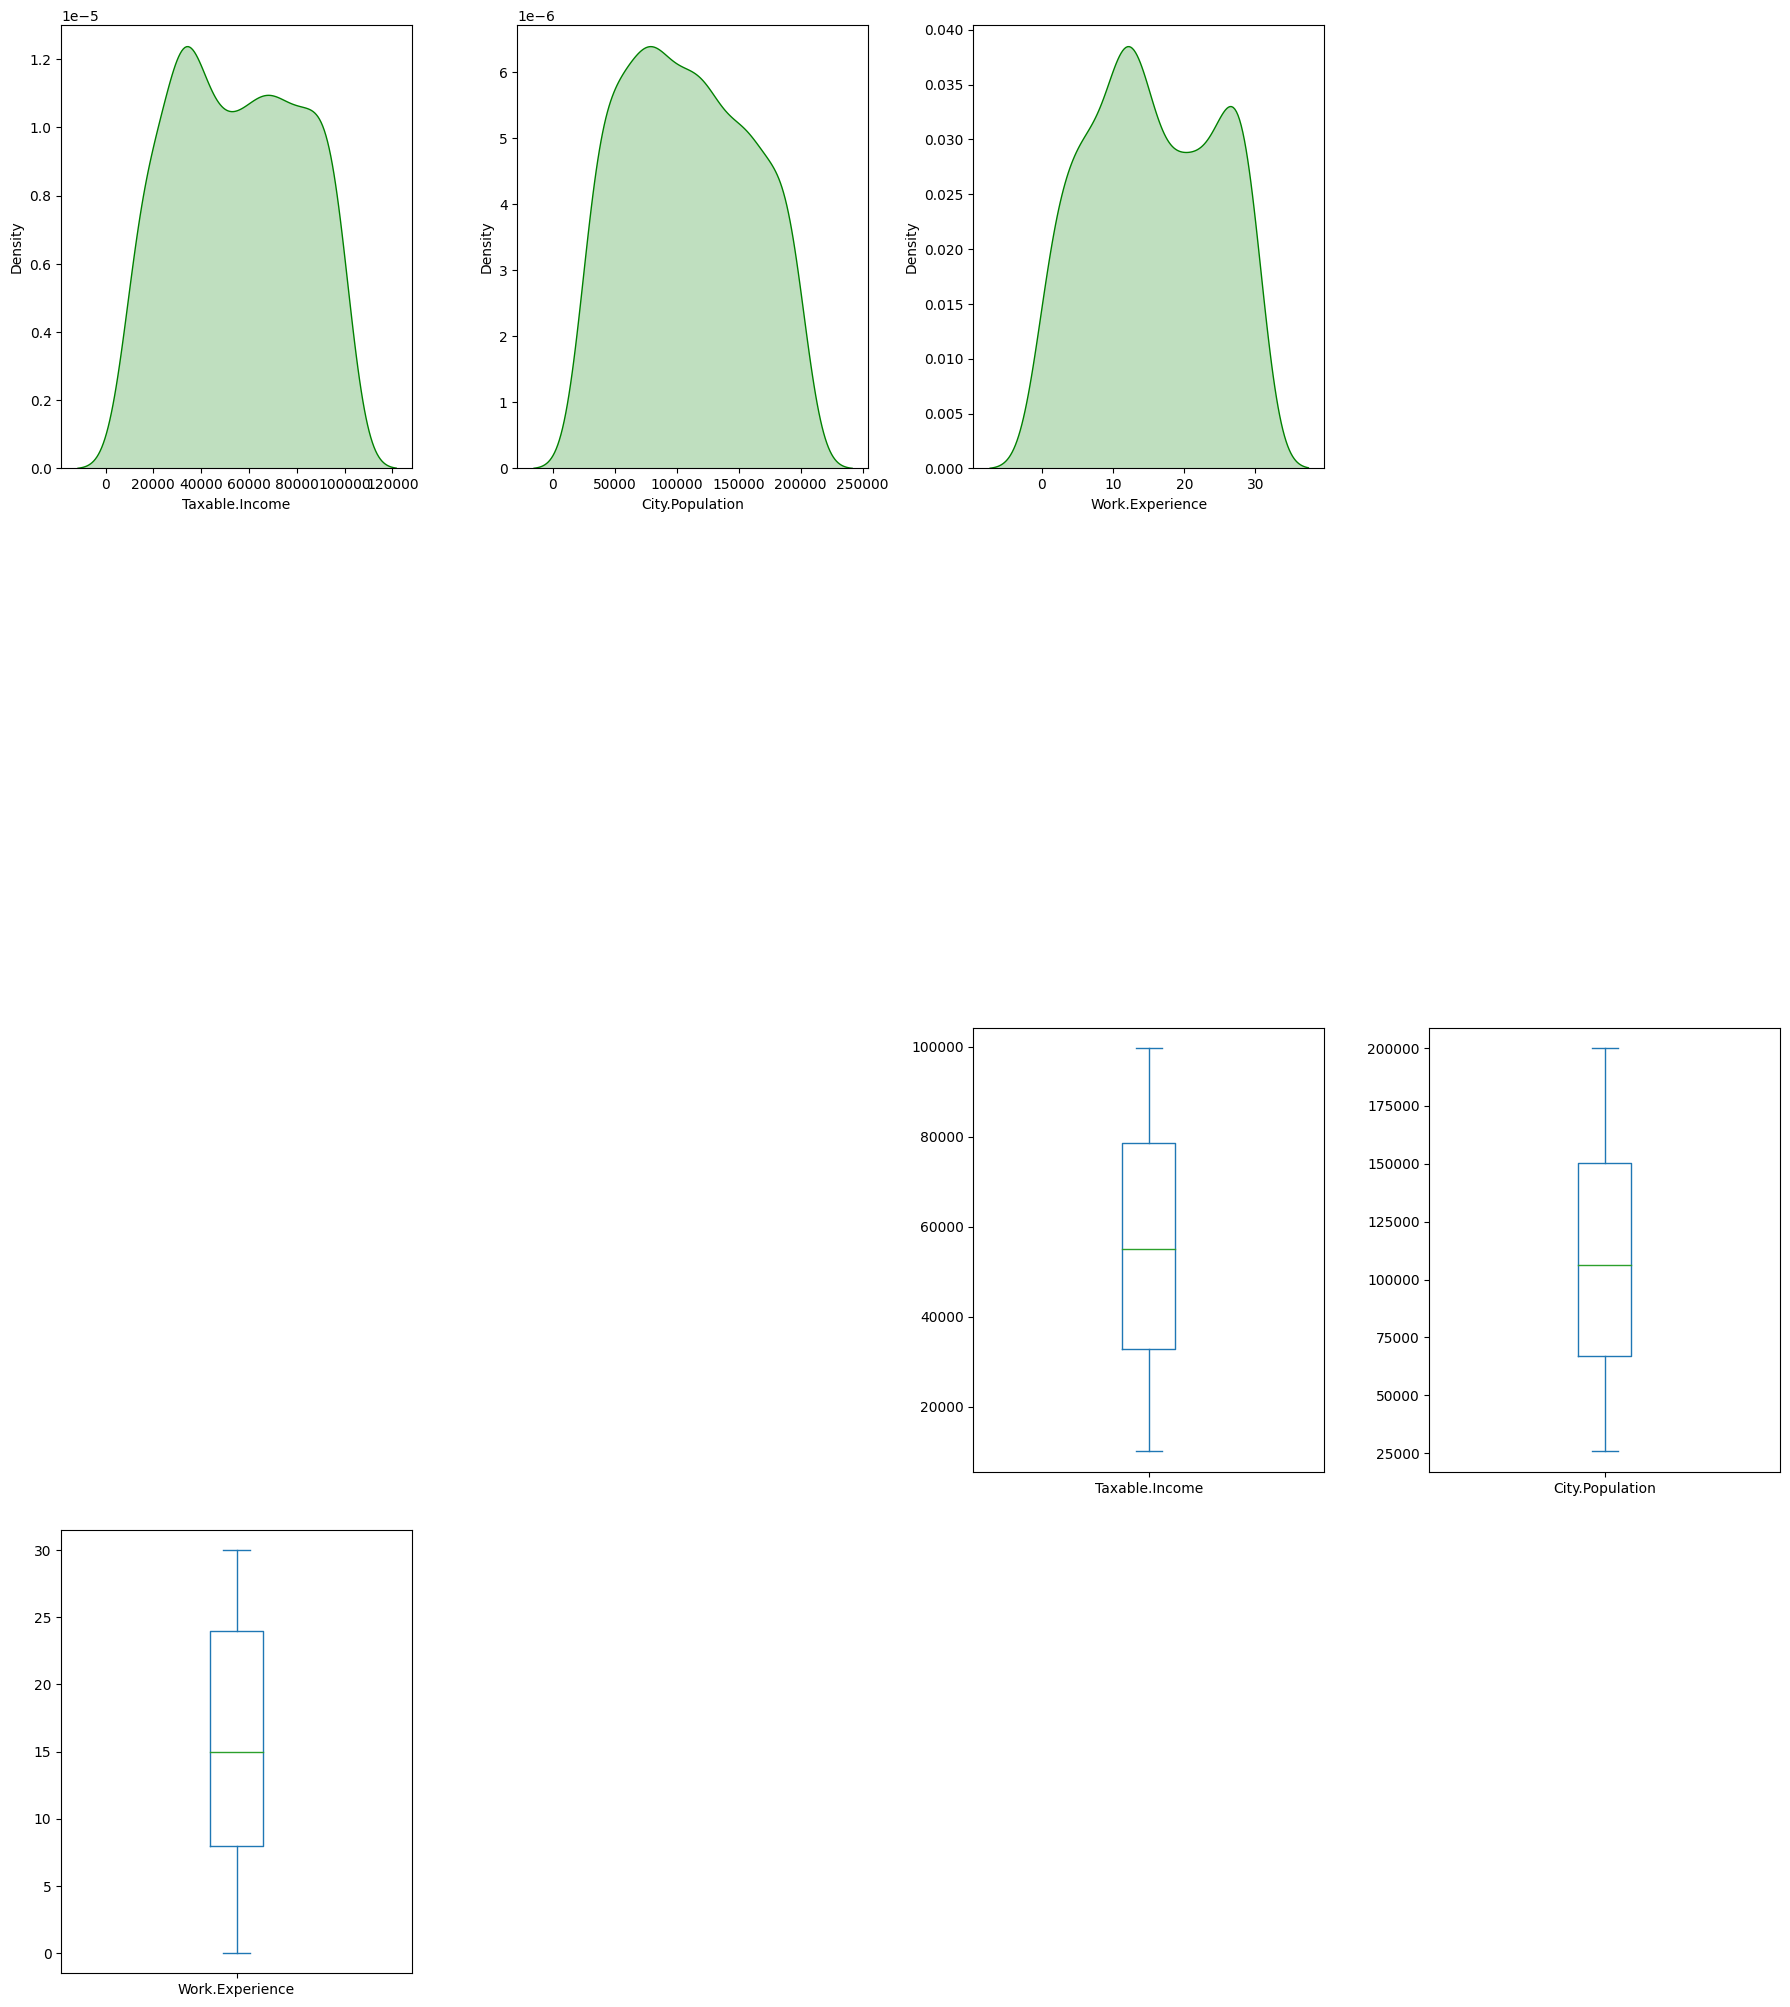

,Taxable.Income,City.Population,Work.Experience
skewness,0.030015,0.125009,0.018529
kurtosis,-1.199782,-1.120154,-1.167524


In [17]:
plt.figure(figsize=(18,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(8,4,i)
    sns.kdeplot(df[col],color='g',shade=True)
    plt.subplot(8,4,i+10)
    df[col].plot.box()
plt.tight_layout() 
plt.show()
num_data = df[num_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

In [18]:
df1 = pd.get_dummies(df1, columns = ['Undergrad','Marital.Status','Urban'])

In [19]:
corr = df1.corr()

In [20]:
corr = df1.corr()

In [21]:
plt.figure(figsize=(10,10))

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Axes: >

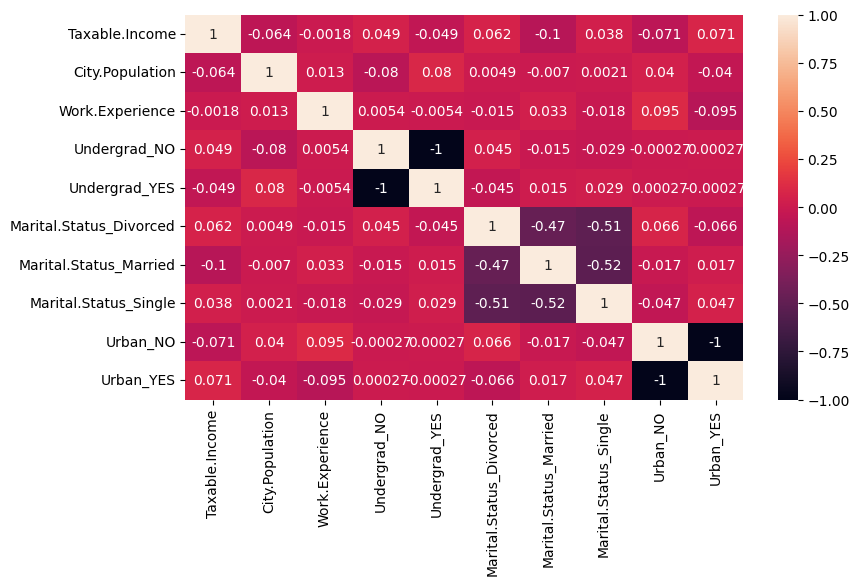

In [22]:
sns.heatmap(corr,annot=True)

## **3 - Decision Tree**

**Since the target variable is continious, we create a class of taxable_income <= 30000 as "Risky" and others are "Good"**

In [23]:
df1['Taxable.Income']=pd.cut(df1['Taxable.Income'],bins=[0,30000,100000],labels=['risky','good'])

In [24]:
list(df1.columns)

['Taxable.Income',
 'City.Population',
 'Work.Experience',
 'Undergrad_NO',
 'Undergrad_YES',
 'Marital.Status_Divorced',
 'Marital.Status_Married',
 'Marital.Status_Single',
 'Urban_NO',
 'Urban_YES']

In [25]:
X = df1.iloc[:,1:10]
y = df1.iloc[:,0]

In [26]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

In [27]:
y_train.value_counts()

good     380
risky    100
Name: Taxable.Income, dtype: int64

In [28]:
model = DT(criterion='entropy') 
model.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy')

In [29]:
pred_train = model.predict(x_train)

In [30]:
accuracy_score(y_train,pred_train)

1.0

In [31]:
confusion_matrix(y_train,pred_train)

array([[380,   0],
       [  0, 100]])

In [32]:
pred_test = model.predict(x_test)

In [33]:
accuracy_score(y_test,pred_test)

0.6666666666666666

In [34]:
confusion_matrix(y_test,pred_test)

array([[77, 19],
       [21,  3]])

In [36]:
df_t=pd.DataFrame({'Actual':y_test, 'Predicted':pred_test})

In [37]:
df_t

,Actual,Predicted
321,good,good
494,good,good
502,good,good
150,good,good
89,risky,risky
...,...,...
438,risky,good
78,good,good
77,good,good
45,good,good


In [38]:
cols = list(df1.columns)

In [40]:
predictors = cols[1:10]

In [41]:
target = cols[0]

In [42]:
dot_data = StringIO()

In [43]:
export_graphviz(model, out_file = dot_data ,filled = True,rounded =True,feature_names = predictors,class_names = target, impurity = False)

In [44]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

In [45]:
graph.write_png('fraud_full.png')

True

## **4 - Conclusion**

**Since the accuracy of the Training set is 100% we test the accurancy on the test data which is 69%**

**As seen in the confusion matrix of Test data 82 instances are presdected correctly and 38 instances are not**

In [48]:
model.feature_importances_

array([0.51945214, 0.26177836, 0.00806729, 0.05557466, 0.00628022,
       0.04041339, 0.03116073, 0.01554779, 0.06172541])

In [49]:
fi = pd.DataFrame({'feature': list(x_train.columns),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)

In [50]:
fi

,feature,importance
0,City.Population,0.519452
1,Work.Experience,0.261778
8,Urban_YES,0.061725
3,Undergrad_YES,0.055575
5,Marital.Status_Married,0.040413
6,Marital.Status_Single,0.031161
7,Urban_NO,0.015548
2,Undergrad_NO,0.008067
4,Marital.Status_Divorced,0.006280
